In [ ]:
Лабораторна робота №2 з курсу 'Основи технологій машинного навчання'

Класифікація видів об’єктів.

Предментна область: ягоди.

Види: 1)полуниця; 2)малина; 3)смородина.

Виконала: студентка групи ТІ-72

Васіна Єлизавета Олександрівна

Виконано у сервісі paperspace gradient.

In [1]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '7fae82d4963544109de35b59e3fd8ca9')

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128)>

In [5]:
""" 
this is customized function because new version of Bing Api do not support code from fastai example
@see: https://forums.fast.ai/t/02-production-permissiondenied-error/65823/24
"""
def search_images_bing(key, term, max_images: int = 150, **kwargs):    
    params = {'q':term, 'count':max_images}
    headers = {"Ocp-Apim-Subscription-Key":key}
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json() 
   
    # returns an L object to be identical to the original function.
    return L(search_results['value'])

search_images_bing

<function __main__.search_images_bing(key, term, max_images: int = 150, **kwargs)>

In [6]:
results = search_images_bing('7fae82d4963544109de35b59e3fd8ca9', 'strawberry')
ims = results.attrgot('contentUrl')
len(ims)

150

In [7]:
results

(#150) [{'webSearchUrl': 'https://www.bing.com/images/search?view=detailv2&FORM=OIIRPO&q=strawberry&id=A75C2D10FAD42E8E1A85869B42C18EFAE5D166B0&simid=608016195338175175', 'name': 'Strawberry - Wikipedia', 'thumbnailUrl': 'https://tse4.mm.bing.net/th?id=OIP.YaqgP3QYWIezoGlhTencDQHaE8&pid=Api', 'datePublished': '2017-02-13T01:03:00.0000000Z', 'isFamilyFriendly': True, 'creativeCommons': 'AttributionShareAlike', 'contentUrl': 'https://upload.wikimedia.org/wikipedia/commons/thumb/7/7e/Strawberry_BNC.jpg/1920px-Strawberry_BNC.jpg', 'hostPageUrl': 'https://en.wikipedia.org/wiki/Strawberry', 'contentSize': '265168 B', 'encodingFormat': 'jpeg', 'hostPageDisplayUrl': 'https://en.wikipedia.org/wiki/Strawberry', 'width': 1920, 'height': 1281, 'hostPageFavIconUrl': 'https://www.bing.com/th?id=ODF.0QY68YH-YG5V7ZPdW4ZxaQ&pid=Api', 'hostPageDomainFriendlyName': 'Wikipedia', 'thumbnail': {'width': 474, 'height': 316}, 'imageInsightsToken': 'ccid_YaqgP3QY*cp_2EB8F18E137B9A9A2B27962829AD2B56*mid_A75C2D1

In [8]:
ims[0]

'https://upload.wikimedia.org/wikipedia/commons/thumb/7/7e/Strawberry_BNC.jpg/1920px-Strawberry_BNC.jpg'

In [9]:
dest = 'images/Strawberry.png'
download_url(ims[0], dest)

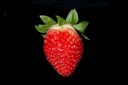

In [10]:
im = Image.open(dest)
im.to_thumb(128,128)

In [11]:
berries_types = 'strawberry','currant','raspberry'
path = Path('berries')

In [12]:
if not path.exists():
    path.mkdir()
    for o in berries_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing('7fae82d4963544109de35b59e3fd8ca9', f'{o} berry')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [13]:
fns = get_image_files(path)
fns

(#446) [Path('berries/strawberry/00000000.jpg'),Path('berries/strawberry/00000002.jpg'),Path('berries/strawberry/00000007.jpg'),Path('berries/strawberry/00000003.jpg'),Path('berries/strawberry/00000004.jpg'),Path('berries/strawberry/00000008.jpeg'),Path('berries/strawberry/00000001.jpg'),Path('berries/strawberry/00000005.jpg'),Path('berries/strawberry/00000006.jpg'),Path('berries/strawberry/00000011.jpg')...]

In [14]:
failed = verify_images(fns)
failed

(#7) [Path('berries/strawberry/00000001.jpg'),Path('berries/strawberry/00000047.jpg'),Path('berries/strawberry/00000073.jpg'),Path('berries/currant/00000127.jpg'),Path('berries/currant/00000145.jpg'),Path('berries/raspberry/00000019.jpg'),Path('berries/raspberry/00000111.jpg')]

In [15]:
failed.map(Path.unlink);

In [16]:
berries = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [17]:
dls = berries.dataloaders(path)

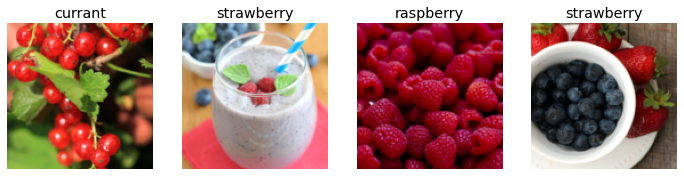

In [18]:
dls.valid.show_batch(max_n=4, nrows=1)

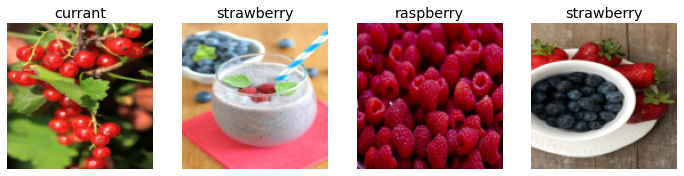

In [19]:
berries = berries.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = berries.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

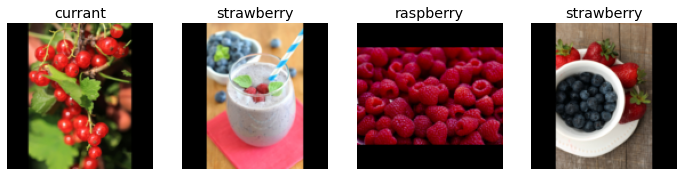

In [20]:
berries = berries.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = berries.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

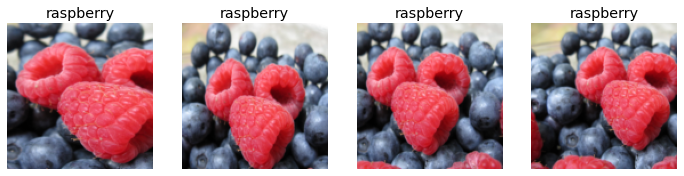

In [21]:
berries = berries.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = berries.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

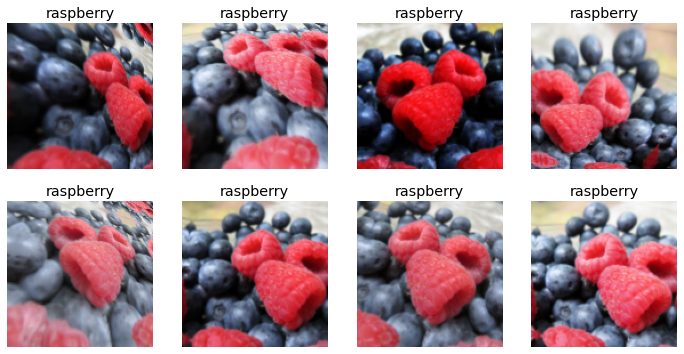

In [22]:
#data augmentation
berries = berries.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = berries.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [23]:
# Training Your Model, and Using It to Clean Your Data
berries = berries.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = berries.dataloaders(path)

In [24]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.695050,0.916466,0.310345,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.942427,0.796576,0.252874,00:13
1,0.787383,0.843460,0.298851,00:13
2,0.681937,0.819601,0.298851,00:13
3,0.583695,0.828595,0.298851,00:13


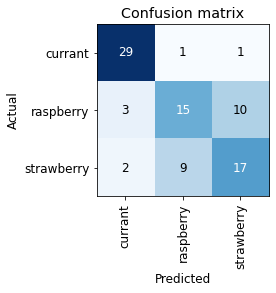

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

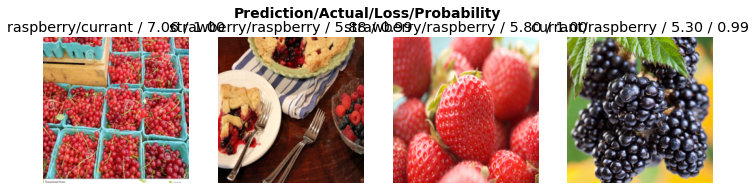

In [26]:
interp.plot_top_losses(4, nrows=1)

In [27]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [28]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [29]:
# Turning Your Model into an Online Application
# Using the Model for Inference
learn.export()

In [30]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [31]:
learn_inf = load_learner(path/'export.pkl')

In [32]:
learn_inf.predict('images/Strawberry.jpg')

('strawberry',
 TensorImage(2),
 TensorImage([6.6444e-05, 2.0126e-04, 9.9973e-01]))

In [33]:
learn_inf.dls.vocab

['currant', 'raspberry', 'strawberry']

In [34]:
# Creating a Notebook App from the Model
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [35]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/Strawberry.jpg'])

In [36]:
img = PILImage.create(btn_upload.data[-1])

In [37]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [38]:
pred,pred_idx,probs = learn_inf.predict(img)

In [39]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: strawberry; Probability: 0.9997')

In [40]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [41]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [42]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [43]:
VBox([widgets.Label('Select your berry!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [44]:
#Turning Your Notebook into a Real App

!pip install voila
!jupyter serverextension enable voila --sys-prefix

     |████████████████████████████████| 1.9 MB 28.5 MB/s eta 0:00:01
     |████████████████████████████████| 223 kB 75.6 MB/s eta 0:00:01
     |████████████████████████████████| 552 kB 31.8 MB/s eta 0:00:01
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

nbdev 1.1.5 requires nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.2.4 OK
